###### Demo Week 9

The following is an introductory demo of the capabilities of GeoPandas, and some corresponding Python libraries, plus an overview on how to import GeoJSON data from a life feed of traffic data as provided by the OpenData website of Transport NSW.

The first half of the tutorial closely follows the example of this GeoPandas tutorial from the GeoHackWeek at the University of Washington (UW):  https://geohackweek.github.io/vector/04-geopandas-intro/
    [Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2018-9-9

Pre-conditions: With Anaconda installed: 
    
    conda install geopandas
    conda install shapely

## 1. Background

[GeoPandas](http://geopandas.org) adds a spatial geometry data type to `Pandas` and enables spatial operations on these types, using [shapely](http://toblerity.org/shapely/). GeoPandas leverages Pandas together with several core open source geospatial packages and practices to provide a uniquely simple and convenient framework for handling geospatial feature data, operating on both geometries and attributes jointly, and as with Pandas, largely eliminating the need to iterate over features (rows). Also as with Pandas, it adds a very convenient and fine-tuned plotting method, and read/write methods that handle multiple file and "serialization" formats.

**_NOTES:_**
- Like `shapely`, these spatial data types are limited to discrete entities/features and do not address continuously varying rasters or fields.
- While GeoPandas spatial objects can be assigned a Coordinate Reference System (`CRS`), operations can not be performed across CRS's. Plus, geodetic ("unprojected", lat-lon) CRS are not handled in a special way; the area of a geodetic polygon will be in degrees.

GeoPandas builds on mature, stable and widely used packages (Pandas, shapely, etc). It is being supported more and more as a preferred Python data structure for geospatial vector data.

**When should you use GeoPandas?**
- For exploratory data analysis, including in Jupyter notebooks.
- For highly compact and readable code. Which in turn improves reproducibility.
- If you're comfortable with Pandas, R dataframes, or tabular/relational approaches.

**When it may not be the best tool?**
- For polished map creation and multi-layer, interactive visualization; if you're comfortable with GIS software, one option is to use a desktop GIS like QGIS! You can generate intermediate GIS files and plots with GeoPandas, then shift over to QGIS. Or refine the plots in Python with matplotlib or additional packages. GeoPandas can help you manage and pre-process the data, and do initial visualizations.
- If you need very high performance, though I'm not sure about current limitations. Performance has been increasing and substantial enhancements are in the works (including possibly a [Dask](http://dask.pydata.org) parallelization implementation).

## 2. Set up packages and data file path
We'll use these throughout the rest of the tutorial.

In [1]:


from __future__ import (absolute_import, division, print_function)
import os
import json

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

data_pth = "./wk09_data/data"

In [2]:
%matplotlib inline

In [3]:
mpl.__version__, pd.__version__, gpd.__version__

('3.1.3', '1.0.3', '0.6.1')

## 3. GeoSeries: The geometry building block

Like a Pandas `Series`, a `GeoSeries` is the building block for the more broadly useful and powerful `GeoDataFrame` that we'll focus on in this tutorial. Here we'll first take a bit of time to examine a `GeoSeries`.

A `GeoSeries` is made up of an index and a GeoPandas `geometry` data type. This data type is a [shapely.geometry object](http://toblerity.org/shapely/manual.html#geometric-objects), and therefore inherits their attributes and methods such as `area`, `bounds`, `distance`, etc.

GeoPandas has six classes of **geometric objects**, corresponding to the three basic single-entity geometric types and their associated homogeneous collections of multiple entities:
- **Single entity (core, basic types):**
  - Point
  - Line (*formally known as a LineString*)
  - Polygon
- **Homogeneous entity collections:**
  - Multi-Point
  - Multi-Line (*MultiLineString*)
  - Multi-Polygon

A `GeoSeries` is then a list of geometry objects and their associated index values.

**_NOTE/WATCH:_**   
Entries (rows) in a GeoSeries can store different geometry types; GeoPandas does not constrain the geometry column to be of the same geometry type. This can lead to unexpected problems if you're not careful! Specially if you're used to thinking of a GIS file format like shape files, which store a single geometry type. Also beware that certain export operations (say, to shape files ...) will fail if the list of geometry objects is heterogeneous.

But enough theory! Let's get our hands dirty (so to speak) with code. We'll start by illustrating how GeoSeries are constructured.

### Create a `GeoSeries` from a list of `shapely Point` objects constructed directly from `WKT` text
**Though you will rarely need this raw approach!**

In [4]:
from shapely.wkt import loads

GeoSeries([loads('POINT(1 2)'), loads('POINT(1.5 2.5)'), loads('POINT(2 3)')])

0    POINT (1.00000 2.00000)
1    POINT (1.50000 2.50000)
2    POINT (2.00000 3.00000)
dtype: geometry

### Create a `GeoSeries` from a list of `shapely Point` objects using the `Point` constructor

In [6]:
gs = GeoSeries([Point(-120, 45), Point(-121.2, 46), Point(-122.9, 47.5)])
gs

0    POINT (-120.00000 45.00000)
1    POINT (-121.20000 46.00000)
2    POINT (-122.90000 47.50000)
dtype: geometry

In [7]:
type(gs), len(gs)

(geopandas.geoseries.GeoSeries, 3)

A GeoSeries (and a GeoDataFrame) can store a CRS implicitly associated with the geometry column. This is useful as essential spatial metadata and for transformation (reprojection) to another CRS. Let's assign the CRS.

In [8]:
gs.crs = {'init': 'epsg:4326'}


The `plot` method accepts standard `matplotlib.pyplot` style options, and can be tweaked like any other `matplotlib` figure.

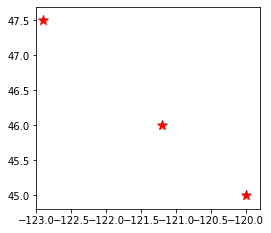

In [9]:
gs.plot(marker='*', color='red', markersize=100, figsize=(4, 4))
plt.xlim([-123, -119.8])
plt.ylim([44.8, 47.7]);

**Let's get a bit fancier, as a stepping stone to GeoDataFrames.** First, we'll define a simple dictionary of lists, that we'll use again later.

In [10]:
data = {'name': ['a', 'b', 'c'],
        'lat': [45, 46, 47.5],
        'lon': [-120, -121.2, -122.9]}
data

{'name': ['a', 'b', 'c'], 'lat': [45, 46, 47.5], 'lon': [-120, -121.2, -122.9]}

Note this convenient, compact approach to create a list of `Point` shapely objects out of X & Y coordinate lists (an alternate approach is shown in the Advanced notebook):

In [11]:
geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
geometry

We'll wrap up by creating a GeoSeries where we explicitly define the index values.

In [13]:
gs = GeoSeries(geometry, index=data['name'])
gs

a    POINT (-120.00000 45.00000)
b    POINT (-121.20000 46.00000)
c    POINT (-122.90000 47.50000)
dtype: geometry

## 4. GeoDataFrames: The real power tool

**_NOTE/HIGHLIGHT:_**   
- It's worth noting that a GeoDataFrame can be described as a *Feature Collection*, where each row is a *Feature*, a *geometry* column is defined (thought the name of the column doesn't have to be "geometry"), and the attribute *Properties* includes the other columns (the Pandas DataFrame part, if you will).
- More than one column can store geometry objects! We won't explore this capability in this tutorial.

### Start with a simple, manually constructed illustration

We'll build on the GeoSeries examples. Let's reuse the `data` dictionary we defined earlier, this time to create a DataFrame.

In [12]:
df = pd.DataFrame(data)
df

,name,lat,lon
0,a,45.0,-120.0
1,b,46.0,-121.2
2,c,47.5,-122.9


Now we use the DataFrame and the "list-of-shapely-Point-objects" approach to create a GeoDataFrame. Note the use of two DataFrame attribute columns, which are effectively just two simple Pandas Series.

In [14]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)
gdf

,name,lat,lon,geometry
0,a,45.0,-120.0,POINT (-120.00000 45.00000)
1,b,46.0,-121.2,POINT (-121.20000 46.00000)
2,c,47.5,-122.9,POINT (-122.90000 47.50000)


There's nothing new to visualize, but this time we're using the `plot` method from a GeoDataFrame, *not* from a GeoSeries. They're not exactly the same thing under the hood.

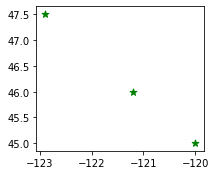

In [15]:
gdf.plot(marker='*', color='green', markersize=50, figsize=(3, 3));

### FINALLY, we get to work with real data! Load and examine the simple "oceans" shape file

`gpd.read_file` is the workhorse for reading GIS files. It leverages the [fiona](http://toblerity.org/fiona/README.html) package.

In [9]:
os.getcwd()

'C:\\Users\\Danny Chacko\\Jupyter_Notebooks'

In [5]:
oceans = gpd.read_file(os.path.join(data_pth, "oceans.shp"))

In [6]:

oceans


,my_polygon,ID,Oceans,geometry
0,S.Atlantic,1,South Atlantic Ocean,"POLYGON ((-67.26026 -59.93092, -67.27089 -58.1..."
1,N.Pacific,0,North Pacific Ocean,"MULTIPOLYGON (((180.00000 66.27035, 180.00000 ..."
2,Southern,3,Southern Ocean,"POLYGON ((180.00000 -60.00000, 180.00000 -90.0..."
3,Arctic,2,Arctic Ocean,"POLYGON ((-100.11965 52.89103, -105.38349 53.3..."
4,Indian,5,Indian Ocean,"POLYGON ((19.69706 -59.94160, 19.72237 -54.348..."
5,S.Pacific,4,South Pacific Ocean,"MULTIPOLYGON (((-180.00000 -60.00000, -180.000..."
6,N.Atlantic,6,North Atlantic Ocean,"POLYGON ((-100.11965 52.89103, -97.40936 53.18..."


In [13]:
len(oceans)

7

The `crs` was read from the shape file's `prj` file:

In [14]:
oceans.crs

{'init': 'epsg:4326'}

Now we finally plot a real map (or blobs, depending on your aesthetics), from a dataset that's global-scale and stored in "geographic" (latitude & longitude) coordinates. It's *not* the actual ocean shapes defined by coastal boundaries, but bear with me. A colormap has been applied to distinguish the different Oceans.

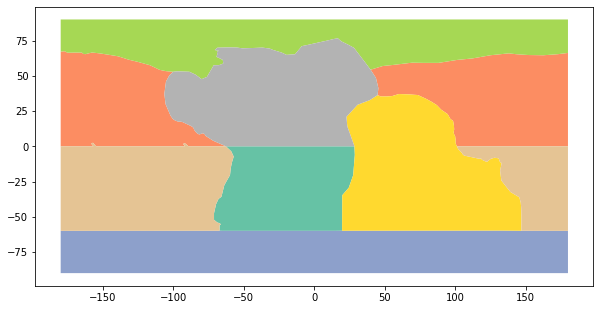

In [15]:
oceans.plot(cmap='Set2', figsize=(10, 10));
# pip install -U --user descartes
# in terminal to set up locally

`oceans.shp` stores both `Polygon` and `Multi-Polygon` geometry types (a `Polygon` may also be viewed as a `Multi-Polygon` with 1 member). We can get at the geometry types and other geometry properties easily.

In [16]:
oceans.geom_type

0         Polygon
1    MultiPolygon
2         Polygon
3         Polygon
4         Polygon
5    MultiPolygon
6         Polygon
dtype: object

In [17]:
# Beware that these area calculations are in degrees, which is fairly useless
oceans.geometry.area

0     5287.751094
1    11805.894558
2    10822.509589
3     9578.786157
4     9047.879388
5     9640.457926
6     8616.721287
dtype: float64

In [18]:
oceans.geometry.bounds

,minx,miny,maxx,maxy
0,-71.183612,-60.000000,28.736134,0.000000
1,-180.000000,0.000000,180.000000,67.479386
2,-180.000000,-90.000000,180.000000,-59.806846
3,-180.000000,47.660532,180.000000,90.000000
4,19.697056,-59.945004,146.991853,37.102940
5,-180.000000,-60.000000,180.000000,2.473291
6,-106.430148,0.000000,45.468236,76.644442


The `envelope` method returns the bounding box for each polygon. This could be used to create a new spatial column or GeoSeries; directly for plotting; etc.

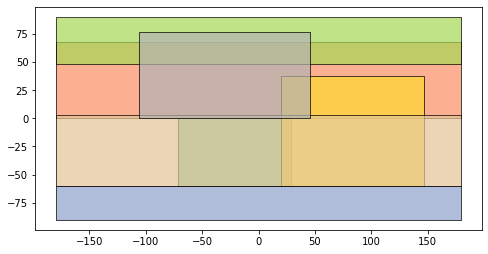

In [19]:
oceans.envelope.plot(cmap='Set2', figsize=(8, 8), alpha=0.7, edgecolor='black');

Does it seem weird that some envelope bounding boxes, such as the North Pacific Ocean, span all longitudes? That's because they're Multi-Polygons with edges at the ends of the -180 and +180 degree coordinate range.

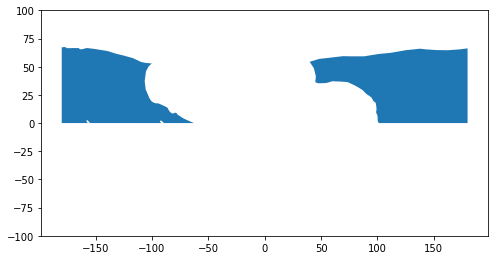

In [20]:
oceans[oceans['Oceans'] == 'North Pacific Ocean'].plot(figsize=(8, 8));
plt.ylim([-100, 100]);

### Load "Natural Earth" countries dataset, bundled with GeoPandas
*"[Natural Earth](http://www.naturalearthdata.com) is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software."* A subset comes bundled with GeoPandas and is accessible from the `gpd.datasets` module. We'll use it as a helpful global base layer map.

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [5]:
len(world)

177

Its CRS is also EPSG:4326:

In [6]:
world.crs

{'init': 'epsg:4326'}

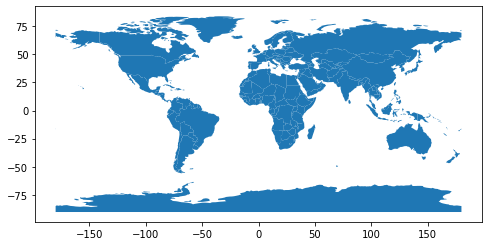

In [7]:
world.plot(figsize=(8, 8));

### Map plot overlays: Plotting multiple spatial layers

Here's a compact, quick way of using the GeoDataFrame plot method to overlay two GeoDataFrames while style customizing the styles for each layer.

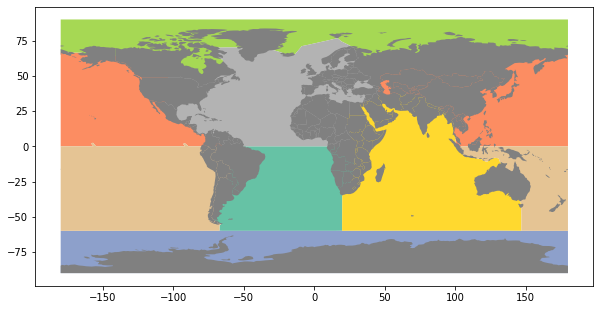

In [21]:
world.plot(ax=oceans.plot(cmap='Set2', figsize=(10, 10)), facecolor='gray');

We can also compose the plot using conventional `matplotlib` steps and options that give us more control.

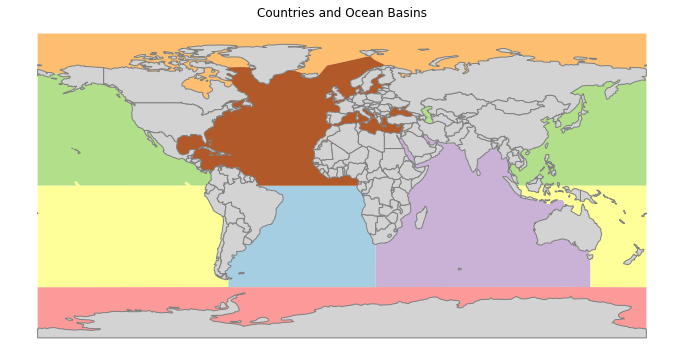

In [22]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.set_title('Countries and Ocean Basins')
# Other nice categorical color maps (cmap) include 'Set2' and 'Set3'
oceans.plot(ax=ax, cmap='Paired')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
ax.set_ylim([-90, 90])
ax.set_axis_off()
plt.axis('equal');

**_NOTE/FUN:_**  
Let's stop for a bit to explore on your own, hack with your neighbors, ask questions.

In [7]:
# use some standard example dataset that come with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities= gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [8]:
cities.head()


,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


In [25]:
len(cities)


202

In [26]:
cities = cities.to_crs(world.crs)

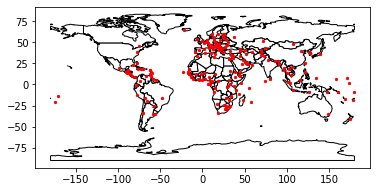

In [27]:
# plot cities on top of base world map (2-layer plot)
base = world.plot(color='white', edgecolor='black')
cities.plot(ax=base, marker='o', color='red', markersize=5);


##### 5. GeoJSON: Read from OGC WFS GeoJSON response into a GeoDataFrame
Use an [Open Geospatial Consortium](http://www.opengeospatial.org) (OGC) [Web Feature Service](https://en.wikipedia.org/wiki/Web_Feature_Service) (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

The following first connects to the OpenData web API service of Transport NSW, and then  retrieves all current traffic hazards from the corresponding **live/hazards/incident/open** endpoint:

In [9]:
import requests
import geojson

# load the authentication credentials from a file
with open(os.path.join(data_pth, "opendata.json")) as f:
    headers_dict = json.load(f) 

In [10]:
# retrieve data from OpenData web service
opendata_url = "https://api.transport.nsw.gov.au/v1/live/hazards/incident/open"

r = requests.get(opendata_url, headers=headers_dict)
r

<Response [200]>

The OpenData API needs authorization via an API key in the http request header. You need to register with the OpenData website (it's free) and generate an application key there first. As it is per-user, we keep it hidden here, but in general the request header looks as follows:

In [11]:
headers_dict['authorization'] = '*****'
headers_dict

{'authorization': '*****', 'Accept': 'application/json'}

In [12]:
fixed_content = r.text.replace("POINT","Point")
# print(r.content)
incidents_geo = geojson.loads(fixed_content)

Let's examine the general characteristics of this GeoJSON object, including its `__geo_interface__` interface, which we discussed earlier.

In [13]:
print(type(incidents_geo))
print(incidents_geo.keys())
print(len(incidents_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'rights', 'layerName', 'lastPublished', 'features'])
55


Now use the `from_features` constructor method to create a GeoDataFrame directly from the  `geojson.feature.FeatureCollection` object.

In [14]:
incidents_gdf = GeoDataFrame.from_features(incidents_geo)

In [15]:
incidents_gdf.head()

,geometry,webLinks,headline,periods,speedLimit,webLinkUrl,expectedDelay,ended,isNewIncident,publicTransport,...,diversions,additionalInfo,webLinkName,attendingGroups,duration,start,displayName,media,roads,encodedPolylines
0,POINT (150.68496 -33.84101),"[{'linkText': 'The Northern Rd upgrade', 'link...",CHANGED TRAFFIC CONDITIONS Traffic switch to n...,"[{'closureType': 'LANE_CLOSURE', 'direction': ...",-1,None,None,False,False,,...,,[ ],None,[ ],NaN,1.579352e+12,CHANGED TRAFFIC CONDITIONS Traffic switch to n...,[],"[{'conditionTendency': '', 'crossStreet': 'Gat...",NaN
1,POINT (151.03879 -33.92301),[{'linkText': 'Stacey Street Improvements (RMS...,CHANGED TRAFFIC CONDITIONS - BANKSTOWN Stacey ...,"[{'closureType': 'LANE_CLOSURE', 'direction': ...",60,None,None,False,False,,...,,[ ],None,[ ],NaN,1.582204e+12,CHANGED TRAFFIC CONDITIONS,[],"[{'conditionTendency': '', 'crossStreet': 'Sta...",NaN
2,POINT (149.69270 -36.86215),[{'linkText': 'Bega Valley Council road closur...,HAZARD Bush fire/flood damage - BEGA VALLEY CO...,[],-1,None,None,False,False,,...,,[ ],None,[Local Council],NaN,NaN,HAZARD Bush fire/flood damage,[],"[{'conditionTendency': '', 'crossStreet': '', ...",NaN
3,POINT (148.49254 -35.86859),[{'linkText': 'Kosciuszko National Park local ...,HAZARD Bush fire damage - KOSCIUSZKO NATIONAL ...,[],-1,None,None,False,False,,...,,[ ],None,[ ],NaN,NaN,HAZARD Bush fire damage,[],"[{'conditionTendency': '', 'crossStreet': '', ...",NaN
4,POINT (150.46189 -35.21769),[{'linkText': 'Shoalhaven Council road conditi...,HAZARD Bush fire/flood damage - SHOALHAVEN COU...,[],-1,None,None,False,False,,...,,[ ],None,[Local Council],NaN,NaN,HAZARD Bush fire/flood damage,[],"[{'conditionTendency': '', 'crossStreet': '', ...",NaN


Finally, let's visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

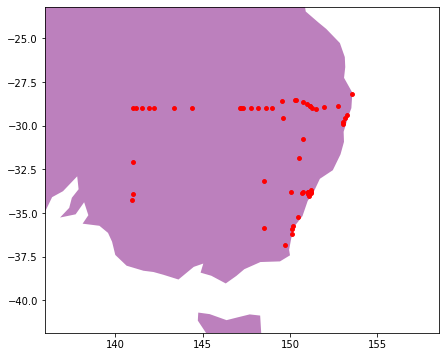

In [18]:
incidents_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
                  marker='o', color='red', markersize=15);
# Use the bounds geometry attribute to set a nice
# geographical extent for the plot, based on the filtered GeoDataFrame
bounds = incidents_gdf.geometry.bounds

plt.xlim([bounds.minx.min()-5, bounds.maxx.max()+5])
plt.ylim([bounds.miny.min()-5, bounds.maxy.max()+5]);

In [19]:
incidents_gdf.iloc[-1]

geometry                                      POINT (151.212518 -33.700722)
webLinks                                                                 []
headline                  CRASH Car, Motorcycle - TERREY HILLS Mona Vale...
periods                                                                  []
speedLimit                                                               -1
webLinkUrl                                                             None
expectedDelay                                                          None
ended                                                                 False
isNewIncident                                                         False
publicTransport                                                            
impactingNetwork                                                       True
subCategoryB                                                               
arrangementAttachments                                                   []
isInitialRep

That's it for the moment. 

Many thanks again to UW for providing this great introductory tutorial on GeoPands on GitHub.

## End of Demo